# Movie Recommender

##Backend

In [1]:
import numpy as np
import pandas as pd
import requests
from IPython.display import Image, HTML, display
import warnings
def warns(*args,**kwargs): pass
warnings.warn=warns
import os
import ast
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
countVec = CountVectorizer(max_features=10000, stop_words='english')
ps = PorterStemmer()

In [2]:
dfmovies = pd.read_csv("/content/tmdb_5000_movies.csv")
dfcredits = pd.read_csv("/content/tmdb_5000_credits.csv")

In [3]:
dfmovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [4]:
dfcredits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [5]:
dfcombine = dfmovies.merge(dfcredits, on='title')
dfcombine.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'movie_id', 'cast', 'crew'],
      dtype='object')

In [6]:
features_cols = ['id', 'title', 'original_title', 'tagline', 'genres', 'keywords', 'cast', 'crew', 'overview']
df_final = dfcombine[features_cols]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              4809 non-null   int64 
 1   title           4809 non-null   object
 2   original_title  4809 non-null   object
 3   tagline         3965 non-null   object
 4   genres          4809 non-null   object
 5   keywords        4809 non-null   object
 6   cast            4809 non-null   object
 7   crew            4809 non-null   object
 8   overview        4806 non-null   object
dtypes: int64(1), object(8)
memory usage: 338.3+ KB


In [7]:
df_final.isnull().sum()

id                  0
title               0
original_title      0
tagline           844
genres              0
keywords            0
cast                0
crew                0
overview            3
dtype: int64

In [8]:
df_final['tagline'] = df_final['tagline'].fillna('unknown')
df_final.dropna(inplace=True)
df_final.isnull().sum()

id                0
title             0
original_title    0
tagline           0
genres            0
keywords          0
cast              0
crew              0
overview          0
dtype: int64

In [9]:
def colData_Transform(obj):
    lst = []
    for i in ast.literal_eval(obj):
        lst.append(i['name'].replace(" ","").lower())
    return lst

def fetch_cast_data(obj):
    lst = []
    counter = 0
    for i in ast.literal_eval(obj):
        if counter < 5:
            lst.append(i['name'].replace(" ","").lower())
            counter += 1
    return lst

def get_crew_data(obj):
    lst = []
    for x in ast.literal_eval(obj):
        if x['job'] == "Director":
            lst.append(x['name'].replace(" ","").lower())
    return lst

In [10]:
df_final['tags'] = df_final['overview'].apply(lambda x: x.lower() and x.split() )
df_final['tags'] = df_final['tags'] + df_final['genres'].apply(colData_Transform)
df_final['tags'] = df_final['tags'] + df_final['keywords'].apply(colData_Transform)
df_final['tags'] = df_final['tags'] + df_final['cast'].apply(fetch_cast_data)
df_final['tags'] = df_final['tags'] + df_final['crew'].apply(get_crew_data)
df_final['tags'] = df_final['tags'] + df_final['title'].apply(lambda x: x.lower() and x.split() )

In [11]:
for x, xRow in df_final.iterrows():
    if (xRow['original_title'] != xRow['title'] ):
        df_final.at[x, 'tags'] = xRow['tags'] + xRow['original_title'].lower().split()

In [12]:
for x, xRow in df_final.iterrows():
    if (xRow['tagline'] != 'unknown'):
        df_final.at[x, 'tags'] = xRow['tags'] + xRow['tagline'].lower().split()

In [13]:
df_new_final = df_final[['id', 'title', 'tags']]
df_new_final['tags'] = df_new_final['tags'].apply(lambda x: " ".join(x).lower())
df_new_final['tags'] = df_new_final['tags'].str.lower()
df_new_final.head()

,id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


In [14]:
def xStem(txt):
    y = []
    for x in txt.split():
        y.append(ps.stem(x))
    return " ".join(y)

In [15]:
df_new_final['tags'] = df_new_final['tags'].apply(xStem)
dataVectors = countVec.fit_transform(df_new_final['tags']).toarray()
similarity = cosine_similarity(dataVectors)

In [16]:
similarity

array([[1.        , 0.11013346, 0.06598588, ..., 0.05458155, 0.        ,
        0.        ],
       [0.11013346, 1.        , 0.06419407, ..., 0.05309942, 0.03241019,
        0.01785714],
       [0.06598588, 0.06419407, 1.        , ..., 0.02120949, 0.        ,
        0.        ],
       ...,
       [0.05458155, 0.05309942, 0.02120949, ..., 1.        , 0.03212463,
        0.05309942],
       [0.        , 0.03241019, 0.        , ..., 0.03212463, 1.        ,
        0.08102547],
       [0.        , 0.01785714, 0.        , ..., 0.05309942, 0.08102547,
        1.        ]])

In [19]:
import joblib

similarity_matrix_path = '/content/similarity_matrix.joblib'
joblib.dump(similarity, similarity_matrix_path)

['/content/similarity_matrix.joblib']

In [160]:
df_new_final_path = '/content/df_new_final.csv'
df_new_final.to_csv(df_new_final_path)

## Frontend

In [24]:
similarity = joblib.load(similarity_matrix_path)

In [161]:
df_new_final = pd.read_csv(df_new_final_path)

In [162]:
def recommend_movies_names(xMovie):
    movie_index = df_new_final[df_new_final["title"].str.lower() == xMovie.lower()].index[0]
    distances = similarity[movie_index]
    listofMovies = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:6]

    for i in listofMovies:
        print(df_new_final.iloc[i[0]]["title"])

In [163]:
movies_list = {"Avatar","Batman","Aliens"}
for x in movies_list:
    print("-"*20, "Recommendations for [", x,"]", "-"*20)
    recommend_movies_names(x)

-------------------- Recommendations for [ Avatar ] --------------------
Aliens
Aliens vs Predator: Requiem
Aliens in the Attic
Titan A.E.
Independence Day
-------------------- Recommendations for [ Aliens ] --------------------
Alien
Alien³
Aliens vs Predator: Requiem
Meet Dave
Aliens in the Attic
-------------------- Recommendations for [ Batman ] --------------------
Batman
Batman & Robin
Batman Begins
Batman Returns
The Dark Knight


# Book Recommender

## Backend

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [147]:
book_df = pd.read_csv('/content/Books.csv')
ratings_df = pd.read_csv('/content/Ratings.csv')
user_df = pd.read_csv('/content/Users.csv')

In [29]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [118]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [31]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [148]:
merged_data = pd.merge(pd.merge(book_df, ratings_df, on='ISBN'), user_df, on='User-ID')

In [88]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35908 entries, 0 to 35907
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 35908 non-null  object 
 1   Book-Title           35908 non-null  object 
 2   Book-Author          35908 non-null  object 
 3   Publisher            35908 non-null  object 
 4   Image-URL-S          35908 non-null  object 
 5   Image-URL-M          35908 non-null  object 
 6   Image-URL-L          35908 non-null  object 
 7   Publication_Date     35908 non-null  object 
 8   Year-Of-Publication  35908 non-null  float64
 9   User-ID              35908 non-null  int64  
 10  Book-Rating          35908 non-null  int64  
 11  Location             35908 non-null  object 
 12  Age                  35908 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 3.6+ MB


In [119]:
merged_data.dropna(inplace=True)
merged_data.reset_index(drop=True, inplace=True)
merged_data.drop(columns=["Image-URL-S", "Image-URL-M", "Image-URL-L"], axis=1, inplace=True)
merged_data = merged_data[merged_data["Book-Rating"] > 0]

In [91]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13471 entries, 0 to 35907
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ISBN                 13471 non-null  object 
 1   Book-Title           13471 non-null  object 
 2   Book-Author          13471 non-null  object 
 3   Publisher            13471 non-null  object 
 4   Publication_Date     13471 non-null  object 
 5   Year-Of-Publication  13471 non-null  float64
 6   User-ID              13471 non-null  int64  
 7   Book-Rating          13471 non-null  int64  
 8   Location             13471 non-null  object 
 9   Age                  13471 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 1.1+ MB


In [120]:
merged_data = merged_data[(merged_data['Age'] >= 5) & (merged_data['Age'] <= 130)]
merged_data['Age'].fillna(merged_data['Age'].mean(), inplace=True)
merged_data.drop_duplicates(inplace=True)

In [121]:
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['5-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65-130']
merged_data['Age-Group'] = pd.cut(merged_data['Age'], bins=bins, labels=labels, right=False)
age_group_ratings = merged_data.groupby('Age-Group')['Book-Rating'].mean()

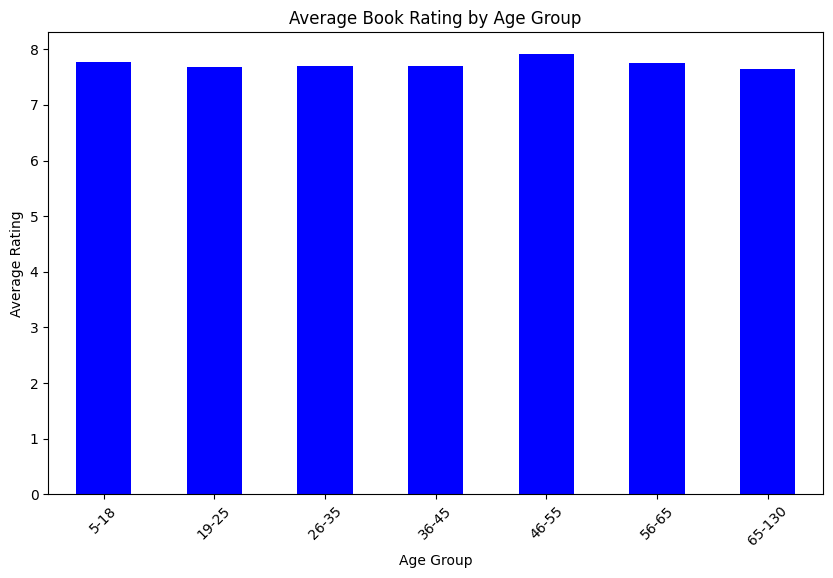

In [122]:
plt.figure(figsize=(10, 6))
age_group_ratings.plot(kind='bar', color='blue')
plt.title('Average Book Rating by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

In [123]:
avg_rating_book = merged_data.groupby('Book-Title').agg(avg_rating=('Book-Rating', 'mean'),rating_count=('Book-Rating', 'count')).reset_index()

In [124]:
rating_90th = avg_rating_book['rating_count'].quantile(0.90)
mean_avg = avg_rating_book['avg_rating'].mean()

avg_rating_book['new_score'] = ((avg_rating_book['avg_rating'] * avg_rating_book['rating_count'] + rating_90th * mean_avg) / (avg_rating_book['rating_count'] + rating_90th))
top = avg_rating_book.sort_values('new_score', ascending=False).head(10)

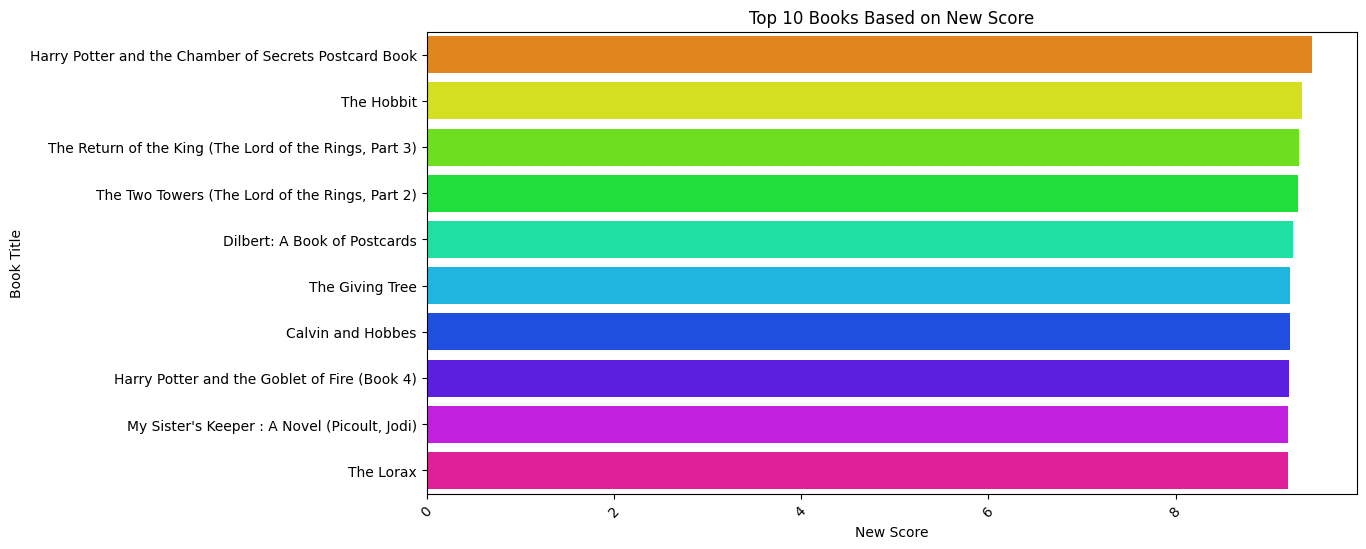

In [125]:
colors = sns.color_palette('hsv', len(top))
plt.figure(figsize=(12, 6))
sns.barplot(data=top, x='new_score', y='Book-Title',palette=colors)
plt.title('Top 10 Books Based on New Score')
plt.xlabel('New Score')
plt.ylabel('Book Title')
plt.xticks(rotation=45)
plt.show()

In [149]:
books_with_ratings = book_df.merge(ratings_df,on='ISBN')

def format_title(title):
    return title.title().strip()

books_with_ratings['Book-Title'] = books_with_ratings['Book-Title'].apply(format_title)

In [150]:
books_with_ratings = books_with_ratings[books_with_ratings['User-ID'].map(books_with_ratings['User-ID'].value_counts()) > 300]
books_with_ratings = books_with_ratings[books_with_ratings['Book-Title'].map(books_with_ratings['Book-Title'].value_counts()) > 100]
books_with_ratings = books_with_ratings.reset_index(drop=True)

In [151]:
book_user_matrix = books_with_ratings.pivot_table(values='Book-Rating', index='Book-Title', columns='User-ID').fillna(0)

In [152]:
book_similarity_matrix = cosine_similarity(book_user_matrix)

In [153]:
import joblib

book_similarity_matrix_path = '/content/book_similarity_matrix.joblib'
joblib.dump(book_similarity_matrix, book_similarity_matrix_path)

['/content/book_similarity_matrix.joblib']

In [155]:
book_user_matrix_path = '/content/book_user_matrix.csv'
book_user_matrix.to_csv(book_user_matrix_path)

## Frontend

In [156]:
book_similarity_matrix = joblib.load(book_similarity_matrix_path)

In [157]:
book_user_matrix = pd.read_csv(book_user_matrix_path, index_col='Book-Title')

In [158]:
def suggest_similar_books(book_name):
    book_idx = np.where(book_user_matrix.index == book_name)[0][0]
    scores = list(enumerate(book_similarity_matrix[book_idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:8]
    book_recommendation = []
    for p in scores:
        temp_df = Merged_data[Merged_data['Book-Title'] == book_user_matrix.index[p[0]]]
        book_recommendation.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
    return book_recommendation

In [159]:
import random
import warnings
warnings.filterwarnings('ignore')
for y in range(4):
    title = random.choice(books_with_ratings['Book-Title'].unique())
    recommended_books = suggest_similar_books(title)
    author = books_with_ratings[books_with_ratings['Book-Title'] == title]['Book-Author'].iloc[0]
    print(f'\n Since you read "{title}" by {author} before.\n \n We recommend these books for you: \n')
    for book in recommended_books:
        print(f'- {book}')
    print("\n------------------\n")


 Since you read "The Notebook" by Nicholas Sparks before.
 
 We recommend these books for you: 

- Lightning
- The Reader
- The Street Lawyer

------------------


 Since you read "The Girls' Guide To Hunting And Fishing" by Melissa Bank before.
 
 We recommend these books for you: 

- Good In Bed
- Midwives: A Novel
- The Nanny Diaries: A Novel
- The Runaway Jury

------------------


 Since you read "The Reader" by Bernhard Schlink before.
 
 We recommend these books for you: 

- The Red Tent (Bestselling Backlist)
- Midwives: A Novel
- Wild Animus

------------------


 Since you read "Message In A Bottle" by Nicholas Sparks before.
 
 We recommend these books for you: 

- The Notebook
- A Painted House
- The Summons
- Red Dragon

------------------

